In [1]:
import numpy as np
from src.Preprocessing import create_labels_single_column
from src.Particle import ParticleType
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict

In [2]:
# loading the data
efps_gluon = np.load("../../../Data/g_efps_d5_primed.npy")
efps_quark = np.load("../../../Data/q_efps_d5_primed.npy")

print(f"Number of Gluon Jets: {efps_gluon.shape[0]}")
print(f"Number of LightQuark Jets: {efps_quark.shape[0]}")

Number of Gluon Jets: 177252
Number of LightQuark Jets: 170679


In [3]:
# joinning the data 
# half of the data represents Top jets, the other half represents non-top quark jets
X = np.vstack((efps_quark, efps_gluon))
y = create_labels_single_column(jet_inputs={ParticleType.Gluon: (efps_quark.shape[0], X.shape[0] - 1), ParticleType.LightQuark: (0, efps_quark.shape[0] - 1)})
# shuffling the data
X, y = shuffle(X, y, random_state=42)

In [4]:
# Let us use the StandardScaler to leave each feature with the same order of magniture
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Dividing the data into trainning, validation, and test
# diving the set into trainning, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Size of the Training set: {X_train.shape[0]}")
print(f"Size of the Validation set: {X_val.shape[0]}")
print(f"Size of the Test set: {X_test.shape[0]}")

Size of the Training set: 251379
Size of the Validation set: 44362
Size of the Test set: 52190


In [9]:
# defining the model
# l2, C = 0.04, solver = lbfgs
# l1, C = 0.0005, solver = saga
log_reg = LogisticRegression(penalty='l1', C=0.0005, solver='saga', max_iter=500)
log_reg.fit(X_train, y_train)

coefs = ', '.join([f'{val:.2f}' for val in log_reg.coef_[0]])
print(f"Coefficients:", coefs)
print(f"Intercept {log_reg.intercept_[0]:.3f}")

Coefficients: -0.74, 0.00, 0.00, 0.00, -0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, -0.18, 0.00, 0.31, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.15, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.14, 0.00, 0.00, 0.00, 0.00, 0.03
Intercept -0.046


In [10]:
print("Non-vanishing coefficients indices:")
best_efps = np.where(abs(log_reg.coef_[0]) > 0)[0]
print(best_efps)

Non-vanishing coefficients indices:
[ 0  4 13 15 39 47 52]


In [11]:
# Tranning set
y_train_predict = log_reg.predict(X_train)

print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train, y_train_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_train, y_train_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_train, y_train_predict, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.68
Precision for Top tagging: 0.60
Confusion Matrix
[[71224 56810]
 [38874 84471]]


In [12]:
y_val_predict = log_reg.predict(X_val)

print("Validation set:")
print(f"Recall for Top tagging: {recall_score(y_val, y_val_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_val, y_val_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val, y_val_predict, labels=[0, 1]))

Validation set:
Recall for Top tagging: 0.69
Precision for Top tagging: 0.60
Confusion Matrix
[[12552 10034]
 [ 6784 14992]]


In [13]:
# evaluating the probabilities of each sample in the trainning data using 
# K-fold cross validation - it returns the probability of the sample in each class
y_probabilities = cross_val_predict(log_reg, X_train, y_train, cv=6, method='predict_proba')

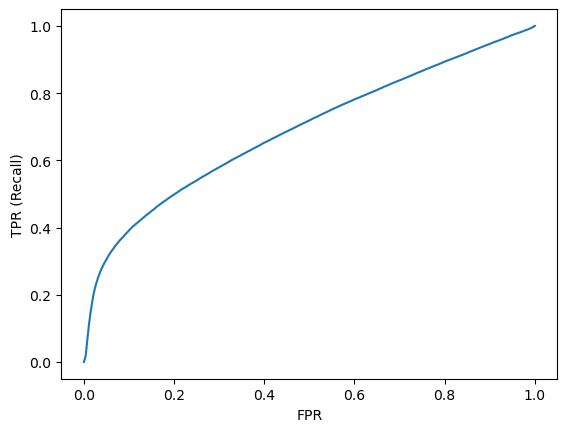

AUC: 0.69


In [14]:
y_score = y_probabilities[:, 1]
plt.plot()
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_train, y_score)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.2f}")